In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'AttUnet_01' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
def dice_coef(y_true, y_pred, smooth=1e-5):
    '''
    Dice coefficient for tensorflow
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: dice coefficient 
    '''
    #if input is not flatten
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    #casting for label from int32 to float32 for computation
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / \
(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def ss_metric(y_true, y_pred, label_type = 'binary', mode = 'global', smooth=1e-5):
    '''
    Compute sensitivity and specificity for groundtruth and prediction
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :label_type: 'binary': input labels is binarized
                 'multi': mutli class labels
    :mode: 'local' compute the sensitivity label wise
           'global' compute the sensitivity overall
    :return: sensitivity & specificity 
    '''
    #if input is not flatten
    if (tf.rank(y_true)!=1 and tf.rank(y_pred)!=1):
        y_true = tf.reshape(y_true, [-1]) #flatten 
        y_pred = tf.reshape(y_pred, [-1]) #flatten
    #label types    
    if label_type =='binary':
        tn, fp, fn, tp = confusion_matrix(y_true , y_pred, labels = [0,1]).ravel()
        sensitivity = (tp+smooth)/(tp+fn+smooth)
        specificity = (tn+smooth)/(tn+fp+smooth)
    if label_type =='multi':
        cm = confusion_matrix(y_true , y_pred, labels = [0,1,2,3])
        #true positive rate 
        if mode=='global':
            tp = np.trace(cm)
            tp_fn = np.sum(cm)
        else: #local
            tp = np.diag(cm)
            tp_fn = np.sum(cm,1)
        sensitivity = (tp+smooth)/(tp_fn+smooth)
        #true negative rate
        diag = np.diag(cm)
        tn = []
        for i in range(len(cm)):
            negs = np.sum([neg for neg in diag if neg!=diag[i]]) 
            tn.append(negs)
        cm_copy = cm
        #make diagonal 0
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    cm_copy[i,j]=0
        if mode=='global':
            tn = np.sum(tn)
            fp = np.sum(cm_copy)
        else: #local
            tn = np.array(tn)
            fp = np.sum(cm_copy, 0)
        specificity = (tn+smooth)/(tn+fp+smooth)
    return sensitivity, specificity

def compute_metric(y_true, y_pred, label_type='binary'):
    '''
    This function compute the metrics specify by BraTS competition
    which is dice coefficient, sensitivity, specificity
    :param y_true: Ground truth image
    :param y_pred: Prediction image from the model
    :label_type: 'binary': input labels is binarized
             'multi': mutli class labels
    :return: dice coefficient, sensitivity & specificity list
            with order ['core', 'enhancing', 'complete']
    '''
    y_list = [y_true, y_pred]
    tumours = ['core', 'enhancing', 'complete']
    dc_output = []
    sens_output = []
    spec_output = []
    #compute dice coefficient for each tumour type
    for tumour_type in tumours:
        if label_type =='multi':
            #label 1, 3(4)
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), lbl, 0) for lbl in y_list]
            #label 3(4)
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, lbl, 0) for lbl in y_list]
            #label 1,2,3,
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>0, lbl, 0) for lbl in y_list]
        if label_type =='binary':
            #label 1, 3(4) =>1
            if tumour_type== 'core':
                y_true, y_pred = [np.where(((lbl==1) | (lbl==3)), 1, 0) for lbl in y_list]
            #label 3(4) =>1
            if tumour_type== 'enhancing':
                y_true, y_pred = [np.where(lbl==3, 1, 0) for lbl in y_list]
            #label 1,2,3 =>1
            if tumour_type== 'complete':
                y_true, y_pred = [np.where(lbl>0, 1, 0) for lbl in y_list]
        dc_list = []
        sens_list = []
        spec_list = []
        for idx in range(len(y_true)): 
            
            y_true_f= tf.reshape(y_true[idx], [-1]) #flatten 
            y_pred_f = tf.reshape(y_pred[idx], [-1]) #flatten

            dc = dice_coef(y_true_f, y_pred_f)
            sensitivity, specificity = ss_metric(y_true_f, y_pred_f)    
            #store values
            dc_list.append(dc)
            sens_list.append(sensitivity)
            spec_list.append(specificity)
        #output [BATCH_SIZE, tumours_type]
        #taking the mean along the batch axis
        mean_ = lambda x: np.mean(x)
        dc_batch_mean = mean_(dc_list)
        sens_batch_mean = mean_(sens_list)
        spec_batch_mean = mean_(spec_list)
        #append for each tumour type
        dc_output.append(dc_batch_mean)
        sens_output.append(sens_batch_mean)
        spec_output.append(spec_batch_mean)
    #for each list the order is as following=> 'core','enhancing','complete'    
    return dc_output, sens_output, spec_output

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply

def attention_block(input_signal, gated_signal, filters):
    #input signal feature maps
    is_fm = Conv2D(filters, kernel_size=(1,1), strides=(2, 2), padding = 'same')(input_signal)
    #gated signal feature maps
    gs_fm = Conv2D(filters, kernel_size=(1,1), strides=(1, 1), padding = 'same')(gated_signal)
    #debugger
    assert is_fm.shape!=gs_fm.shape, "Feature maps shape doesn't match!"
    #element wise sum
    add = Add()([is_fm, gs_fm])
    acti = Activation('relu')(add)
    #downsampled attention coefficient 
    bottle_neck = Conv2D(1, kernel_size=(1,1), activation='sigmoid')(acti)
    #bilinear interpolation to get attention coeffcient
    alpha = UpSampling2D(interpolation='bilinear')(bottle_neck)
    #filter off input signal's features with attention coefficient 
    multi = Multiply()([input_signal, alpha])
    return multi

def AttUnet_model(input_layer, attention_mode='grid'):
    #downsampling path
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



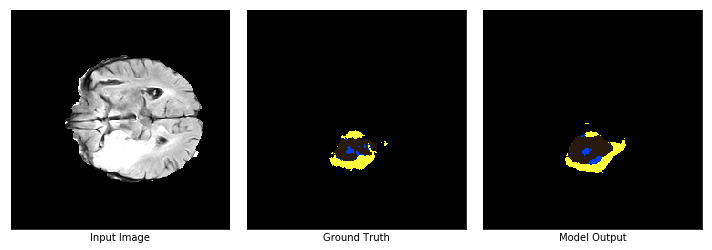

Steps: 2000, Loss:0.018987972289323807
Accurary: 0.9854340553283691
Dice coefficient: [0.9417774, 0.94148576, 0.9505217]
Sensitivity: [0.9990913388318499, 0.9930396100458078, 0.9911966307740029]
Specificity: [0.9928287229074684, 0.9933647846112835, 0.9907864772868652]
Gradient min:-0.005644379649311304, max:0.006192702800035477

Epochs  2



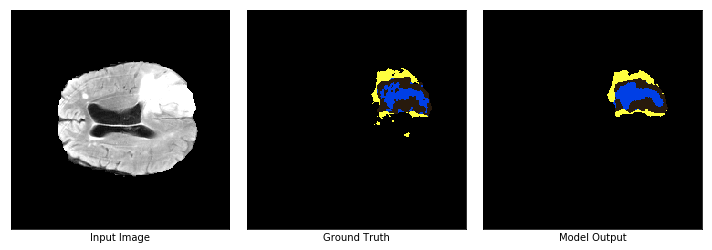

Steps: 2000, Loss:0.0059770685620605946
Accurary: 0.9898611307144165
Dice coefficient: [0.96218395, 0.9382114, 0.9321511]
Sensitivity: [0.9564765305992846, 0.9262639785108365, 0.928211510454131]
Specificity: [0.9996636216046435, 0.9985990382198712, 0.9993163006891185]
Gradient min:-0.00244984682649374, max:0.0031169105786830187

Epochs  3



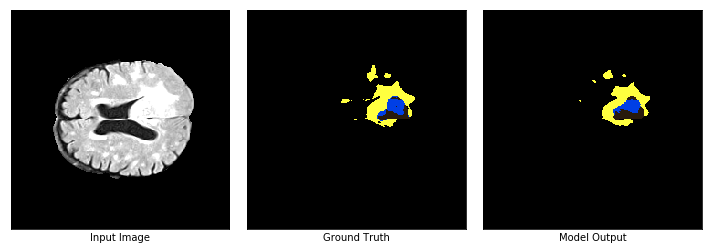

Steps: 2000, Loss:0.007006484549492598
Accurary: 0.9918403029441833
Dice coefficient: [0.98310673, 0.9707807, 0.93003684]
Sensitivity: [0.9819059032919885, 0.9833036180886819, 0.9167320813305719]
Specificity: [0.9989788777689128, 0.9985663909796998, 0.9993147509253101]
Gradient min:-0.0014853471657261252, max:0.0013231955235823989

Epochs  4



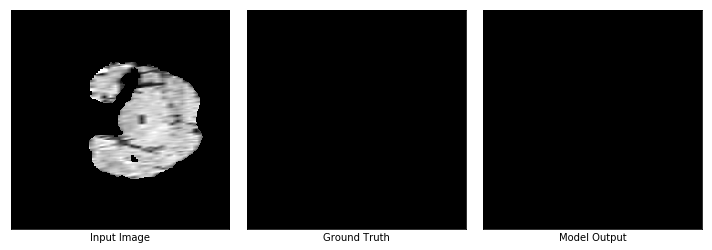

Steps: 2000, Loss:0.005952212493866682
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0011849321890622377, max:0.0014605210162699223

Epochs  5



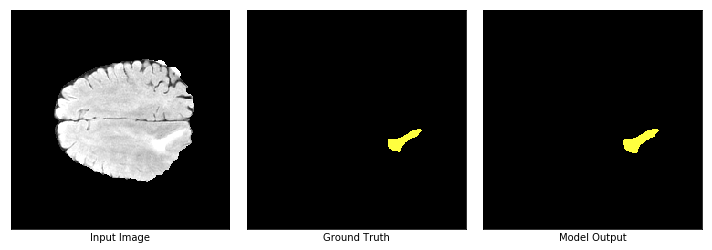

Steps: 2000, Loss:0.007633836939930916
Accurary: 0.9984722137451172
Dice coefficient: [1.0, 1.0, 0.9826254]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 0.9983846577612433]
Gradient min:-0.00292568770237267, max:0.003895651549100876

-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9967384338378906
Mean Dice coefficient: [0.92848265 0.91174453 0.9080728 ]
Mean Sensitivity: [0.945614   0.94067519 0.91990752]
Mean Specificity: [0.99971931 0.99956398 0.99939167]
------------------------------------------------


Epochs  6



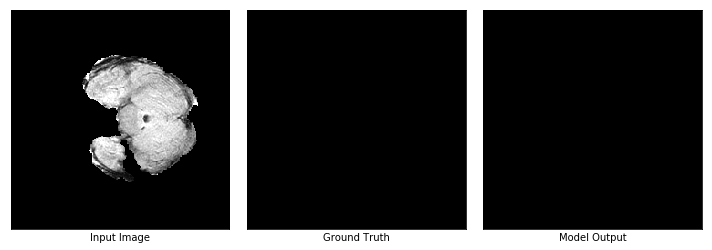

Steps: 2000, Loss:0.0015468867495656013
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0004217459645587951, max:0.0004282707814127207

Epochs  7



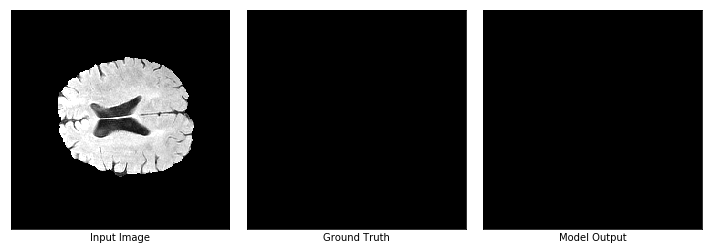

Steps: 2000, Loss:0.0038401249330490828
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.002513427985832095, max:0.002146195387467742

Epochs  8



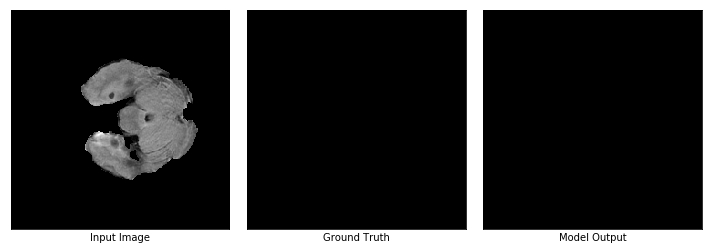

Steps: 2000, Loss:0.004656518343836069
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.004766429308801889, max:0.0033724531531333923

Epochs  9



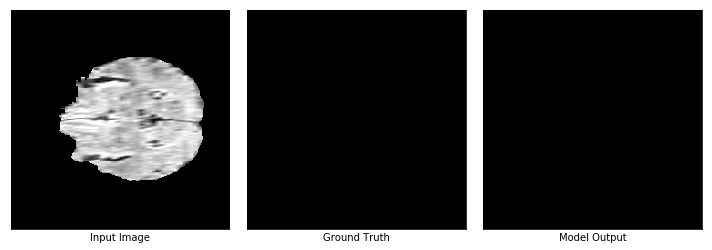

Steps: 2000, Loss:0.004571389406919479
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0013609951129183173, max:0.0011088113533332944

Epochs 10



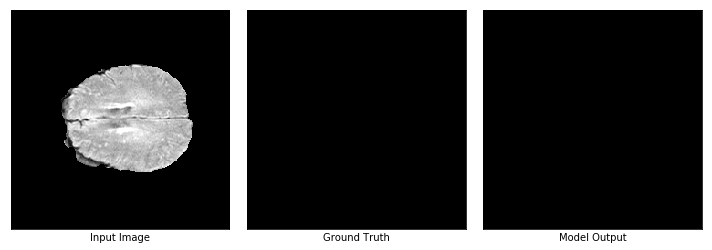

Steps: 2000, Loss:0.0059579298831522465
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0023867932613939047, max:0.003716966835781932

-----------<Summary for Epoch:10>------------
Mean Accuracy: 0.9975365400314331
Mean Dice coefficient: [0.95289236 0.93863845 0.9380852 ]
Mean Sensitivity: [0.95896759 0.95286291 0.94162928]
Mean Specificity: [0.99980707 0.99969185 0.99952972]
------------------------------------------------


Epochs 11



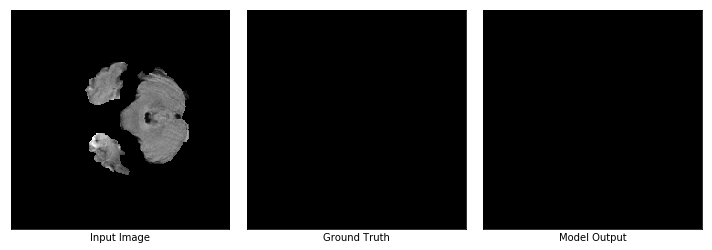

Steps: 2000, Loss:0.005707805044949055
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0008825724362395704, max:0.001417215564288199

Epochs 12



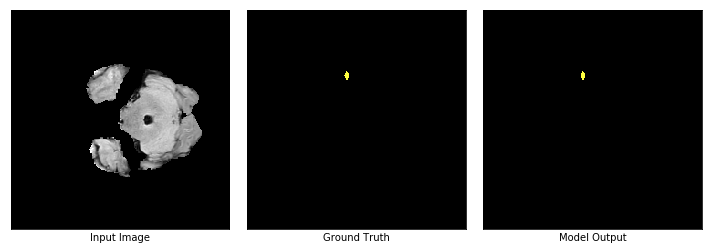

Steps: 2000, Loss:0.0036617100704461336
Accurary: 0.999965250492096
Dice coefficient: [1.0, 1.0, 0.9987879]
Sensitivity: [1.0, 1.0, 0.9993055567129611]
Specificity: [1.0, 1.0, 0.9999824929979345]
Gradient min:-0.0008929609321057796, max:0.0008531659259460866

Epochs 13



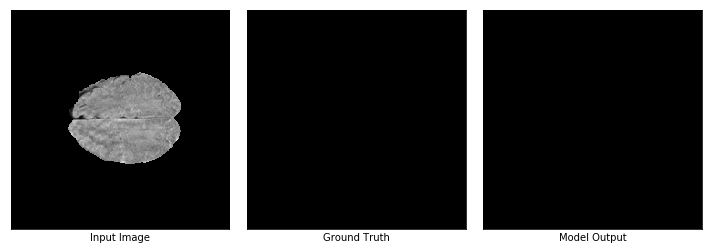

Steps: 2000, Loss:0.0037189803551882505
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0010872100247070193, max:0.0011323755607008934

Epochs 14



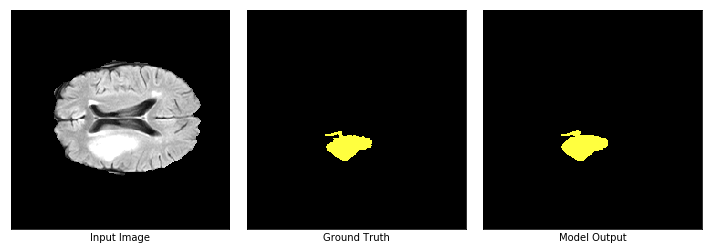

Steps: 2000, Loss:0.0048945071175694466
Accurary: 0.9985764026641846
Dice coefficient: [1.0, 1.0, 0.98775977]
Sensitivity: [1.0, 1.0, 0.9995330217358086]
Specificity: [1.0, 1.0, 0.9984472270527545]
Gradient min:-0.002447472419589758, max:0.0023967016022652388

Epochs 15


In [ ]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
def val_fn(image, label):
    Unet.load_weights('/home/kevinteng/Desktop/model_weights/Unet_{}.h5'.format(ver))
    Unet.trainable = False
    model_output = model(image)
    loss = xent(label, model_output)
    return model_output, loss

In [ ]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [ ]:
Unet.summary()